In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [5]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 172014
Total Plays: 1210147


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

Clean Drives: 171110


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [8]:
off_play_types

['Pass Completion',
 'Rush',
 'Pass Incompletion',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [9]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return 0 if (x.play_type.isin(st_types)) else (ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep)

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = np.vectorize(assign_eqppp_vector)(pbp_data.play_type, pbp_data.yard_line, pbp_data.yards_gained)

In [10]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
1,1,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
2,2,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
3,3,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,26,35,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000
4,4,322430009005,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,11,47,3,6.0,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,2.359414,2012,0.476408


In [11]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [121]:
inputs = ['OffSR','FP','OppRate','OppEff','OppPPD','OppSR', 'ExpTO', 'ActualTO','IsoPPP','AvgEqPPP','HavocRate','FGEff','ExpOppPPD']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.isin(off_play_types))
        & ((pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False)))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal")]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point")]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) yds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","PlayText","Distance","Return","Net"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = tmp.values
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: kickoff_plays.yards_gained[x.Index],axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
    kickoff_sr = verify_division(len(kickoff_distance[kickoff_distance.Net >= 40]), len(kickoff_distance))
    kick_return_sr = verify_division(len(kickoff_distance[kickoff_distance.Return >= 24]), len(kickoff_distance))
    
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        'KickoffSR' : [kickoff_sr],
        'KickReturnSR' : [kick_return_sr]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin
#     print(type(value))

    # Convert the left range into a 0-1 range (float)
    if ((~isinstance(value, pd.Series)) & (~isinstance(value, pd.DataFrame)) & (~(isinstance(value,  pd.core.series.Series)))):
        valueScaled = float(value - inputMin) / float(leftSpan)
        # Convert the 0-1 range into a value in the right range.
        return outputMin + (valueScaled * rightSpan)
    else:
        valueScaled = value.apply(lambda x: x - inputMin / leftSpan)
        return valueScaled.apply(lambda x: outputMin + (x * rightSpan))


def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 100)
    
def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min(), pbp_data.EqPPP.max(), 0, 100)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 100)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,100)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 100)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = np.vectorize(assign_eqppp_vector)(game_pbp.play_type, game_pbp.yard_line, game_pbp.yards_gained)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')

    home_team_st_stats = generate_team_special_teams_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_special_teams_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    home_team_stats["ExpOppPPD"] = 10 * (home_team_stats.OppSR * 0.335 + translate(home_team_stats.AvgEqPPP, game_pbp.EqPPP.min(),game_pbp.EqPPP.max(),0,1) * .385 + home_team_stats.OffSR * 0.23 + home_team_stats.FGEff * 0.05)
    away_team_stats["ExpOppPPD"] = 10 * (away_team_stats.OppSR * 0.335 + translate(away_team_stats.AvgEqPPP, game_pbp.EqPPP.min(),game_pbp.EqPPP.max(),0,1) * .385 + away_team_stats.OffSR * 0.23 + away_team_stats.FGEff * 0.05)
    
    cols = ["team"]
    for inpt in inputs:
        cols.append(f"{inpt}Diff")
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    cols.append('5FR')
    cols.append('5FRDiff')
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box

box = calculate_box_score(401013183, 2018)
# print(box[["FP","OppPPD"]])
box

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,ExpTODiff,ActualTODiff,IsoPPPDiff,AvgEqPPPDiff,HavocRateDiff,FGEffDiff,ExpOppPPDDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,-0.66,-1,0.124959,0.103211,-0.033753,0.333333,0.734125,48.033161,4.021333
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,0.66,1,-0.124959,-0.103211,0.033753,-0.333333,-0.734125,44.011828,-4.021333


In [122]:
box_comps = pd.DataFrame(data={'Team':box.Team})
box_comps['Eff'] = box.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
box_comps['Expl'] = box.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
box_comps['FinDrv'] = box.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
box_comps['FldPos'] = box.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
box_comps['Trnovr'] = box.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
box_comps['5FR'] = box['5FR']
box_comps

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR
0,Virginia,17.997076,11.325207,9.419643,4.46,4.831236,48.033161
1,Virginia Tech,17.002924,10.719783,5.580357,5.54,5.168764,44.011828


In [123]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()
    

Relying on 'stored_game_boxes' currently loaded into memory
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 4973 box score groups by GameID.
[1/4973] Updating 5FR Margin for game_id 322430041...
[1/4973] Updated 5FR Margin for game_id 322430041.
[2/4973] Updating 5FR Margin for game_id 322430238...
[2/4973] Updated 5FR Margin for game_id 322430238.
[3/4973] Updating 5FR Margin for game_id 322430242...
[3/4973] Updated 5FR Margin for game_id 322430242.
[4/4973] Updating 5FR Margin for game_id 322430252...
[4/4973] Updated 5FR Margin for game_id 322430252.
[5/4973] Updating 5FR Margin for game_id 322432006...
[5/4973] Updated 5FR Margin for game_id 322432006.
[6/4973] Updating 5FR Margin for game_id 322432050...
[6/4973] Updated 5FR Margin for game_id 322432050.
[7/4973] Updating 5FR Margin for game_id 322432439...
[7/4973] Updated 5FR Margin for game_id 322432439.
[8/4973] Updating 5FR Margin 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[211/4973] Updating 5FR Margin for game_id 322730333...
[211/4973] Updated 5FR Margin for game_id 322730333.
[212/4973] Updating 5FR Margin for game_id 322730356...
[212/4973] Updated 5FR Margin for game_id 322730356.
[213/4973] Updating 5FR Margin for game_id 322732005...
[213/4973] Updated 5FR Margin for game_id 322732005.
[214/4973] Updating 5FR Margin for game_id 322732006...
[214/4973] Updated 5FR Margin for game_id 322732006.
[215/4973] Updating 5FR Margin for game_id 322732032...
[215/4973] Updated 5FR Margin for game_id 322732032.
[216/4973] Updating 5FR Margin for game_id 322732116...
[216/4973] Updated 5FR Margin for game_id 322732116.
[217/4973] Updating 5FR Margin for game_id 322732132...
[217/4973] Updated 5FR Margin for game_id 322732132.
[218/4973] Updating 5FR Margin for game_id 322732226...
[218/4973] Updated 5FR Margin for game_id 322732226.
[219/4973] Updating 5FR Margin for game_id 322732294...
[219/4973] Updated 5FR Margin for game_id 322732294.
[220/4973] Updatin

[436/4973] Updating 5FR Margin for game_id 323012433...
[436/4973] Updated 5FR Margin for game_id 323012433.
[437/4973] Updating 5FR Margin for game_id 323012483...
[437/4973] Updated 5FR Margin for game_id 323012483.
[438/4973] Updating 5FR Margin for game_id 323012567...
[438/4973] Updated 5FR Margin for game_id 323012567.
[439/4973] Updating 5FR Margin for game_id 323012579...
[439/4973] Updated 5FR Margin for game_id 323012579.
[440/4973] Updating 5FR Margin for game_id 323012636...
[440/4973] Updated 5FR Margin for game_id 323012636.
[441/4973] Updating 5FR Margin for game_id 323012655...
[441/4973] Updated 5FR Margin for game_id 323012655.
[442/4973] Updating 5FR Margin for game_id 323012711...
[442/4973] Updated 5FR Margin for game_id 323012711.
[443/4973] Updating 5FR Margin for game_id 323012751...
[443/4973] Updated 5FR Margin for game_id 323012751.
[444/4973] Updating 5FR Margin for game_id 323060098...
[444/4973] Updated 5FR Margin for game_id 323060098.
[445/4973] Updating

[661/4973] Updating 5FR Margin for game_id 323292751...
[661/4973] Updated 5FR Margin for game_id 323292751.
[662/4973] Updating 5FR Margin for game_id 323340164...
[662/4973] Updated 5FR Margin for game_id 323340164.
[663/4973] Updating 5FR Margin for game_id 323350024...
[663/4973] Updated 5FR Margin for game_id 323350024.
[664/4973] Updating 5FR Margin for game_id 323352309...
[664/4973] Updated 5FR Margin for game_id 323352309.
[665/4973] Updating 5FR Margin for game_id 323360041...
[665/4973] Updated 5FR Margin for game_id 323360041.
[666/4973] Updating 5FR Margin for game_id 323360058...
[666/4973] Updated 5FR Margin for game_id 323360058.
[667/4973] Updating 5FR Margin for game_id 323360059...
[667/4973] Updated 5FR Margin for game_id 323360059.
[668/4973] Updating 5FR Margin for game_id 323360061...
[668/4973] Updated 5FR Margin for game_id 323360061.
[669/4973] Updating 5FR Margin for game_id 323360062...
[669/4973] Updated 5FR Margin for game_id 323360062.
[670/4973] Updating

[882/4973] Updated 5FR Margin for game_id 332710264.
[883/4973] Updating 5FR Margin for game_id 332710265...
[883/4973] Updated 5FR Margin for game_id 332710265.
[884/4973] Updating 5FR Margin for game_id 332710277...
[884/4973] Updated 5FR Margin for game_id 332710277.
[885/4973] Updating 5FR Margin for game_id 332710326...
[885/4973] Updated 5FR Margin for game_id 332710326.
[886/4973] Updating 5FR Margin for game_id 332710333...
[886/4973] Updated 5FR Margin for game_id 332710333.
[887/4973] Updating 5FR Margin for game_id 332710356...
[887/4973] Updated 5FR Margin for game_id 332710356.
[888/4973] Updating 5FR Margin for game_id 332712050...
[888/4973] Updated 5FR Margin for game_id 332712050.
[889/4973] Updating 5FR Margin for game_id 332712084...
[889/4973] Updated 5FR Margin for game_id 332712084.
[890/4973] Updating 5FR Margin for game_id 332712116...
[890/4973] Updated 5FR Margin for game_id 332712116.
[891/4973] Updating 5FR Margin for game_id 332712348...
[891/4973] Updated 

[1101/4973] Updated 5FR Margin for game_id 332992628.
[1102/4973] Updating 5FR Margin for game_id 332992636...
[1102/4973] Updated 5FR Margin for game_id 332992636.
[1103/4973] Updating 5FR Margin for game_id 332992655...
[1103/4973] Updated 5FR Margin for game_id 332992655.
[1104/4973] Updating 5FR Margin for game_id 333030235...
[1104/4973] Updated 5FR Margin for game_id 333030235.
[1105/4973] Updating 5FR Margin for game_id 333040248...
[1105/4973] Updated 5FR Margin for game_id 333040248.
[1106/4973] Updating 5FR Margin for game_id 333040249...
[1106/4973] Updated 5FR Margin for game_id 333040249.
[1107/4973] Updating 5FR Margin for game_id 333040265...
[1107/4973] Updated 5FR Margin for game_id 333040265.
[1108/4973] Updating 5FR Margin for game_id 333042653...
[1108/4973] Updated 5FR Margin for game_id 333042653.
[1109/4973] Updating 5FR Margin for game_id 333050204...
[1109/4973] Updated 5FR Margin for game_id 333050204.
[1110/4973] Updating 5FR Margin for game_id 333060005...
[

[1323/4973] Updated 5FR Margin for game_id 333332117.
[1324/4973] Updating 5FR Margin for game_id 333332226...
[1324/4973] Updated 5FR Margin for game_id 333332226.
[1325/4973] Updating 5FR Margin for game_id 333332483...
[1325/4973] Updated 5FR Margin for game_id 333332483.
[1326/4973] Updating 5FR Margin for game_id 333332653...
[1326/4973] Updated 5FR Margin for game_id 333332653.
[1327/4973] Updating 5FR Margin for game_id 333340002...
[1327/4973] Updated 5FR Margin for game_id 333340002.
[1328/4973] Updating 5FR Margin for game_id 333340005...
[1328/4973] Updated 5FR Margin for game_id 333340005.
[1329/4973] Updating 5FR Margin for game_id 333340009...
[1329/4973] Updated 5FR Margin for game_id 333340009.
[1330/4973] Updating 5FR Margin for game_id 333340024...
[1330/4973] Updated 5FR Margin for game_id 333340024.
[1331/4973] Updating 5FR Margin for game_id 333340030...
[1331/4973] Updated 5FR Margin for game_id 333340030.
[1332/4973] Updating 5FR Margin for game_id 333340036...
[

[1548/4973] Updated 5FR Margin for game_id 400756976.
[1549/4973] Updating 5FR Margin for game_id 400756977...
[1549/4973] Updated 5FR Margin for game_id 400756977.
[1550/4973] Updating 5FR Margin for game_id 400756978...
[1550/4973] Updated 5FR Margin for game_id 400756978.
[1551/4973] Updating 5FR Margin for game_id 400756979...
[1551/4973] Updated 5FR Margin for game_id 400756979.
[1552/4973] Updating 5FR Margin for game_id 400756980...
[1552/4973] Updated 5FR Margin for game_id 400756980.
[1553/4973] Updating 5FR Margin for game_id 400756981...
[1553/4973] Updated 5FR Margin for game_id 400756981.
[1554/4973] Updating 5FR Margin for game_id 400756982...
[1554/4973] Updated 5FR Margin for game_id 400756982.
[1555/4973] Updating 5FR Margin for game_id 400756983...
[1555/4973] Updated 5FR Margin for game_id 400756983.
[1556/4973] Updating 5FR Margin for game_id 400756984...
[1556/4973] Updated 5FR Margin for game_id 400756984.
[1557/4973] Updating 5FR Margin for game_id 400756985...
[

[1774/4973] Updated 5FR Margin for game_id 400763559.
[1775/4973] Updating 5FR Margin for game_id 400763560...
[1775/4973] Updated 5FR Margin for game_id 400763560.
[1776/4973] Updating 5FR Margin for game_id 400763561...
[1776/4973] Updated 5FR Margin for game_id 400763561.
[1777/4973] Updating 5FR Margin for game_id 400763562...
[1777/4973] Updated 5FR Margin for game_id 400763562.
[1778/4973] Updating 5FR Margin for game_id 400763563...
[1778/4973] Updated 5FR Margin for game_id 400763563.
[1779/4973] Updating 5FR Margin for game_id 400763564...
[1779/4973] Updated 5FR Margin for game_id 400763564.
[1780/4973] Updating 5FR Margin for game_id 400763565...
[1780/4973] Updated 5FR Margin for game_id 400763565.
[1781/4973] Updating 5FR Margin for game_id 400763566...
[1781/4973] Updated 5FR Margin for game_id 400763566.
[1782/4973] Updating 5FR Margin for game_id 400763567...
[1782/4973] Updated 5FR Margin for game_id 400763567.
[1783/4973] Updating 5FR Margin for game_id 400763568...
[

[1998/4973] Updating 5FR Margin for game_id 400787329...
[1998/4973] Updated 5FR Margin for game_id 400787329.
[1999/4973] Updating 5FR Margin for game_id 400787330...
[1999/4973] Updated 5FR Margin for game_id 400787330.
[2000/4973] Updating 5FR Margin for game_id 400787331...
[2000/4973] Updated 5FR Margin for game_id 400787331.
[2001/4973] Updating 5FR Margin for game_id 400787332...
[2001/4973] Updated 5FR Margin for game_id 400787332.
[2002/4973] Updating 5FR Margin for game_id 400787333...
[2002/4973] Updated 5FR Margin for game_id 400787333.
[2003/4973] Updating 5FR Margin for game_id 400787334...
[2003/4973] Updated 5FR Margin for game_id 400787334.
[2004/4973] Updating 5FR Margin for game_id 400787335...
[2004/4973] Updated 5FR Margin for game_id 400787335.
[2005/4973] Updating 5FR Margin for game_id 400787336...
[2005/4973] Updated 5FR Margin for game_id 400787336.
[2006/4973] Updating 5FR Margin for game_id 400787337...
[2006/4973] Updated 5FR Margin for game_id 400787337.
[

[2219/4973] Updated 5FR Margin for game_id 400869059.
[2220/4973] Updating 5FR Margin for game_id 400869062...
[2220/4973] Updated 5FR Margin for game_id 400869062.
[2221/4973] Updating 5FR Margin for game_id 400869064...
[2221/4973] Updated 5FR Margin for game_id 400869064.
[2222/4973] Updating 5FR Margin for game_id 400869065...
[2222/4973] Updated 5FR Margin for game_id 400869065.
[2223/4973] Updating 5FR Margin for game_id 400869066...
[2223/4973] Updated 5FR Margin for game_id 400869066.
[2224/4973] Updating 5FR Margin for game_id 400869067...
[2224/4973] Updated 5FR Margin for game_id 400869067.
[2225/4973] Updating 5FR Margin for game_id 400869068...
[2225/4973] Updated 5FR Margin for game_id 400869068.
[2226/4973] Updating 5FR Margin for game_id 400869069...
[2226/4973] Updated 5FR Margin for game_id 400869069.
[2227/4973] Updating 5FR Margin for game_id 400869070...
[2227/4973] Updated 5FR Margin for game_id 400869070.
[2228/4973] Updating 5FR Margin for game_id 400869071...
[

[2441/4973] Updating 5FR Margin for game_id 400869337...
[2441/4973] Updated 5FR Margin for game_id 400869337.
[2442/4973] Updating 5FR Margin for game_id 400869338...
[2442/4973] Updated 5FR Margin for game_id 400869338.
[2443/4973] Updating 5FR Margin for game_id 400869339...
[2443/4973] Updated 5FR Margin for game_id 400869339.
[2444/4973] Updating 5FR Margin for game_id 400869340...
[2444/4973] Updated 5FR Margin for game_id 400869340.
[2445/4973] Updating 5FR Margin for game_id 400869341...
[2445/4973] Updated 5FR Margin for game_id 400869341.
[2446/4973] Updating 5FR Margin for game_id 400869342...
[2446/4973] Updated 5FR Margin for game_id 400869342.
[2447/4973] Updating 5FR Margin for game_id 400869345...
[2447/4973] Updated 5FR Margin for game_id 400869345.
[2448/4973] Updating 5FR Margin for game_id 400869347...
[2448/4973] Updated 5FR Margin for game_id 400869347.
[2449/4973] Updating 5FR Margin for game_id 400869348...
[2449/4973] Updated 5FR Margin for game_id 400869348.
[

[2660/4973] Updated 5FR Margin for game_id 400869617.
[2661/4973] Updating 5FR Margin for game_id 400869618...
[2661/4973] Updated 5FR Margin for game_id 400869618.
[2662/4973] Updating 5FR Margin for game_id 400869620...
[2662/4973] Updated 5FR Margin for game_id 400869620.
[2663/4973] Updating 5FR Margin for game_id 400869621...
[2663/4973] Updated 5FR Margin for game_id 400869621.
[2664/4973] Updating 5FR Margin for game_id 400869622...
[2664/4973] Updated 5FR Margin for game_id 400869622.
[2665/4973] Updating 5FR Margin for game_id 400869623...
[2665/4973] Updated 5FR Margin for game_id 400869623.
[2666/4973] Updating 5FR Margin for game_id 400869627...
[2666/4973] Updated 5FR Margin for game_id 400869627.
[2667/4973] Updating 5FR Margin for game_id 400869628...
[2667/4973] Updated 5FR Margin for game_id 400869628.
[2668/4973] Updating 5FR Margin for game_id 400869629...
[2668/4973] Updated 5FR Margin for game_id 400869629.
[2669/4973] Updating 5FR Margin for game_id 400869630...
[

[2879/4973] Updated 5FR Margin for game_id 400933932.
[2880/4973] Updating 5FR Margin for game_id 400933933...
[2880/4973] Updated 5FR Margin for game_id 400933933.
[2881/4973] Updating 5FR Margin for game_id 400933934...
[2881/4973] Updated 5FR Margin for game_id 400933934.
[2882/4973] Updating 5FR Margin for game_id 400933935...
[2882/4973] Updated 5FR Margin for game_id 400933935.
[2883/4973] Updating 5FR Margin for game_id 400933936...
[2883/4973] Updated 5FR Margin for game_id 400933936.
[2884/4973] Updating 5FR Margin for game_id 400933937...
[2884/4973] Updated 5FR Margin for game_id 400933937.
[2885/4973] Updating 5FR Margin for game_id 400933938...
[2885/4973] Updated 5FR Margin for game_id 400933938.
[2886/4973] Updating 5FR Margin for game_id 400934489...
[2886/4973] Updated 5FR Margin for game_id 400934489.
[2887/4973] Updating 5FR Margin for game_id 400934492...
[2887/4973] Updated 5FR Margin for game_id 400934492.
[2888/4973] Updating 5FR Margin for game_id 400934493...
[

[3097/4973] Updating 5FR Margin for game_id 400935380...
[3097/4973] Updated 5FR Margin for game_id 400935380.
[3098/4973] Updating 5FR Margin for game_id 400935381...
[3098/4973] Updated 5FR Margin for game_id 400935381.
[3099/4973] Updating 5FR Margin for game_id 400935382...
[3099/4973] Updated 5FR Margin for game_id 400935382.
[3100/4973] Updating 5FR Margin for game_id 400935383...
[3100/4973] Updated 5FR Margin for game_id 400935383.
[3101/4973] Updating 5FR Margin for game_id 400935384...
[3101/4973] Updated 5FR Margin for game_id 400935384.
[3102/4973] Updating 5FR Margin for game_id 400935385...
[3102/4973] Updated 5FR Margin for game_id 400935385.
[3103/4973] Updating 5FR Margin for game_id 400935386...
[3103/4973] Updated 5FR Margin for game_id 400935386.
[3104/4973] Updating 5FR Margin for game_id 400935387...
[3104/4973] Updated 5FR Margin for game_id 400935387.
[3105/4973] Updating 5FR Margin for game_id 400935388...
[3105/4973] Updated 5FR Margin for game_id 400935388.
[

[3329/4973] Updating 5FR Margin for game_id 400941836...
[3329/4973] Updated 5FR Margin for game_id 400941836.
[3330/4973] Updating 5FR Margin for game_id 400941837...
[3330/4973] Updated 5FR Margin for game_id 400941837.
[3331/4973] Updating 5FR Margin for game_id 400941838...
[3331/4973] Updated 5FR Margin for game_id 400941838.
[3332/4973] Updating 5FR Margin for game_id 400941839...
[3332/4973] Updated 5FR Margin for game_id 400941839.
[3333/4973] Updating 5FR Margin for game_id 400941840...
[3333/4973] Updated 5FR Margin for game_id 400941840.
[3334/4973] Updating 5FR Margin for game_id 400941841...
[3334/4973] Updated 5FR Margin for game_id 400941841.
[3335/4973] Updating 5FR Margin for game_id 400941842...
[3335/4973] Updated 5FR Margin for game_id 400941842.
[3336/4973] Updating 5FR Margin for game_id 400941843...
[3336/4973] Updated 5FR Margin for game_id 400941843.
[3337/4973] Updating 5FR Margin for game_id 400941844...
[3337/4973] Updated 5FR Margin for game_id 400941844.
[

[3561/4973] Updated 5FR Margin for game_id 401012310.
[3562/4973] Updating 5FR Margin for game_id 401012311...
[3562/4973] Updated 5FR Margin for game_id 401012311.
[3563/4973] Updating 5FR Margin for game_id 401012312...
[3563/4973] Updated 5FR Margin for game_id 401012312.
[3564/4973] Updating 5FR Margin for game_id 401012313...
[3564/4973] Updated 5FR Margin for game_id 401012313.
[3565/4973] Updating 5FR Margin for game_id 401012314...
[3565/4973] Updated 5FR Margin for game_id 401012314.
[3566/4973] Updating 5FR Margin for game_id 401012315...
[3566/4973] Updated 5FR Margin for game_id 401012315.
[3567/4973] Updating 5FR Margin for game_id 401012316...
[3567/4973] Updated 5FR Margin for game_id 401012316.
[3568/4973] Updating 5FR Margin for game_id 401012317...
[3568/4973] Updated 5FR Margin for game_id 401012317.
[3569/4973] Updating 5FR Margin for game_id 401012318...
[3569/4973] Updated 5FR Margin for game_id 401012318.
[3570/4973] Updating 5FR Margin for game_id 401012319...
[

[3791/4973] Updated 5FR Margin for game_id 401013071.
[3792/4973] Updating 5FR Margin for game_id 401013074...
[3792/4973] Updated 5FR Margin for game_id 401013074.
[3793/4973] Updating 5FR Margin for game_id 401013075...
[3793/4973] Updated 5FR Margin for game_id 401013075.
[3794/4973] Updating 5FR Margin for game_id 401013076...
[3794/4973] Updated 5FR Margin for game_id 401013076.
[3795/4973] Updating 5FR Margin for game_id 401013077...
[3795/4973] Updated 5FR Margin for game_id 401013077.
[3796/4973] Updating 5FR Margin for game_id 401013078...
[3796/4973] Updated 5FR Margin for game_id 401013078.
[3797/4973] Updating 5FR Margin for game_id 401013086...
[3797/4973] Updated 5FR Margin for game_id 401013086.
[3798/4973] Updating 5FR Margin for game_id 401013087...
[3798/4973] Updated 5FR Margin for game_id 401013087.
[3799/4973] Updating 5FR Margin for game_id 401013089...
[3799/4973] Updated 5FR Margin for game_id 401013089.
[3800/4973] Updating 5FR Margin for game_id 401013095...
[

[4022/4973] Updated 5FR Margin for game_id 401016407.
[4023/4973] Updating 5FR Margin for game_id 401016408...
[4023/4973] Updated 5FR Margin for game_id 401016408.
[4024/4973] Updating 5FR Margin for game_id 401016409...
[4024/4973] Updated 5FR Margin for game_id 401016409.
[4025/4973] Updating 5FR Margin for game_id 401016410...
[4025/4973] Updated 5FR Margin for game_id 401016410.
[4026/4973] Updating 5FR Margin for game_id 401019470...
[4026/4973] Updated 5FR Margin for game_id 401019470.
[4027/4973] Updating 5FR Margin for game_id 401019475...
[4027/4973] Updated 5FR Margin for game_id 401019475.
[4028/4973] Updating 5FR Margin for game_id 401019477...
[4028/4973] Updated 5FR Margin for game_id 401019477.
[4029/4973] Updating 5FR Margin for game_id 401019478...
[4029/4973] Updated 5FR Margin for game_id 401019478.
[4030/4973] Updating 5FR Margin for game_id 401019479...
[4030/4973] Updated 5FR Margin for game_id 401019479.
[4031/4973] Updating 5FR Margin for game_id 401019482...
[

[4257/4973] Updating 5FR Margin for game_id 401110778...
[4257/4973] Updated 5FR Margin for game_id 401110778.
[4258/4973] Updating 5FR Margin for game_id 401110779...
[4258/4973] Updated 5FR Margin for game_id 401110779.
[4259/4973] Updating 5FR Margin for game_id 401110780...
[4259/4973] Updated 5FR Margin for game_id 401110780.
[4260/4973] Updating 5FR Margin for game_id 401110781...
[4260/4973] Updated 5FR Margin for game_id 401110781.
[4261/4973] Updating 5FR Margin for game_id 401110783...
[4261/4973] Updated 5FR Margin for game_id 401110783.
[4262/4973] Updating 5FR Margin for game_id 401110784...
[4262/4973] Updated 5FR Margin for game_id 401110784.
[4263/4973] Updating 5FR Margin for game_id 401110785...
[4263/4973] Updated 5FR Margin for game_id 401110785.
[4264/4973] Updating 5FR Margin for game_id 401110786...
[4264/4973] Updated 5FR Margin for game_id 401110786.
[4265/4973] Updating 5FR Margin for game_id 401110787...
[4265/4973] Updated 5FR Margin for game_id 401110787.
[

[4490/4973] Updated 5FR Margin for game_id 401112258.
[4491/4973] Updating 5FR Margin for game_id 401112259...
[4491/4973] Updated 5FR Margin for game_id 401112259.
[4492/4973] Updating 5FR Margin for game_id 401112260...
[4492/4973] Updated 5FR Margin for game_id 401112260.
[4493/4973] Updating 5FR Margin for game_id 401112261...
[4493/4973] Updated 5FR Margin for game_id 401112261.
[4494/4973] Updating 5FR Margin for game_id 401112262...
[4494/4973] Updated 5FR Margin for game_id 401112262.
[4495/4973] Updating 5FR Margin for game_id 401112263...
[4495/4973] Updated 5FR Margin for game_id 401112263.
[4496/4973] Updating 5FR Margin for game_id 401112264...
[4496/4973] Updated 5FR Margin for game_id 401112264.
[4497/4973] Updating 5FR Margin for game_id 401112265...
[4497/4973] Updated 5FR Margin for game_id 401112265.
[4498/4973] Updating 5FR Margin for game_id 401112266...
[4498/4973] Updated 5FR Margin for game_id 401112266.
[4499/4973] Updating 5FR Margin for game_id 401112268...
[

[4720/4973] Updating 5FR Margin for game_id 401114314...
[4720/4973] Updated 5FR Margin for game_id 401114314.
[4721/4973] Updating 5FR Margin for game_id 401114315...
[4721/4973] Updated 5FR Margin for game_id 401114315.
[4722/4973] Updating 5FR Margin for game_id 401114316...
[4722/4973] Updated 5FR Margin for game_id 401114316.
[4723/4973] Updating 5FR Margin for game_id 401114317...
[4723/4973] Updated 5FR Margin for game_id 401114317.
[4724/4973] Updating 5FR Margin for game_id 401114318...
[4724/4973] Updated 5FR Margin for game_id 401114318.
[4725/4973] Updating 5FR Margin for game_id 401114319...
[4725/4973] Updated 5FR Margin for game_id 401114319.
[4726/4973] Updating 5FR Margin for game_id 401114320...
[4726/4973] Updated 5FR Margin for game_id 401114320.
[4727/4973] Updating 5FR Margin for game_id 401114321...
[4727/4973] Updated 5FR Margin for game_id 401114321.
[4728/4973] Updating 5FR Margin for game_id 401114322...
[4728/4973] Updated 5FR Margin for game_id 401114322.
[

[4946/4973] Updating 5FR Margin for game_id 401121966...
[4946/4973] Updated 5FR Margin for game_id 401121966.
[4947/4973] Updating 5FR Margin for game_id 401121967...
[4947/4973] Updated 5FR Margin for game_id 401121967.
[4948/4973] Updating 5FR Margin for game_id 401121968...
[4948/4973] Updated 5FR Margin for game_id 401121968.
[4949/4973] Updating 5FR Margin for game_id 401121969...
[4949/4973] Updated 5FR Margin for game_id 401121969.
[4950/4973] Updating 5FR Margin for game_id 401121970...
[4950/4973] Updated 5FR Margin for game_id 401121970.
[4951/4973] Updating 5FR Margin for game_id 401121971...
[4951/4973] Updated 5FR Margin for game_id 401121971.
[4952/4973] Updating 5FR Margin for game_id 401121972...
[4952/4973] Updated 5FR Margin for game_id 401121972.
[4953/4973] Updating 5FR Margin for game_id 401121973...
[4953/4973] Updated 5FR Margin for game_id 401121973.
[4954/4973] Updating 5FR Margin for game_id 401121974...
[4954/4973] Updated 5FR Margin for game_id 401121974.
[

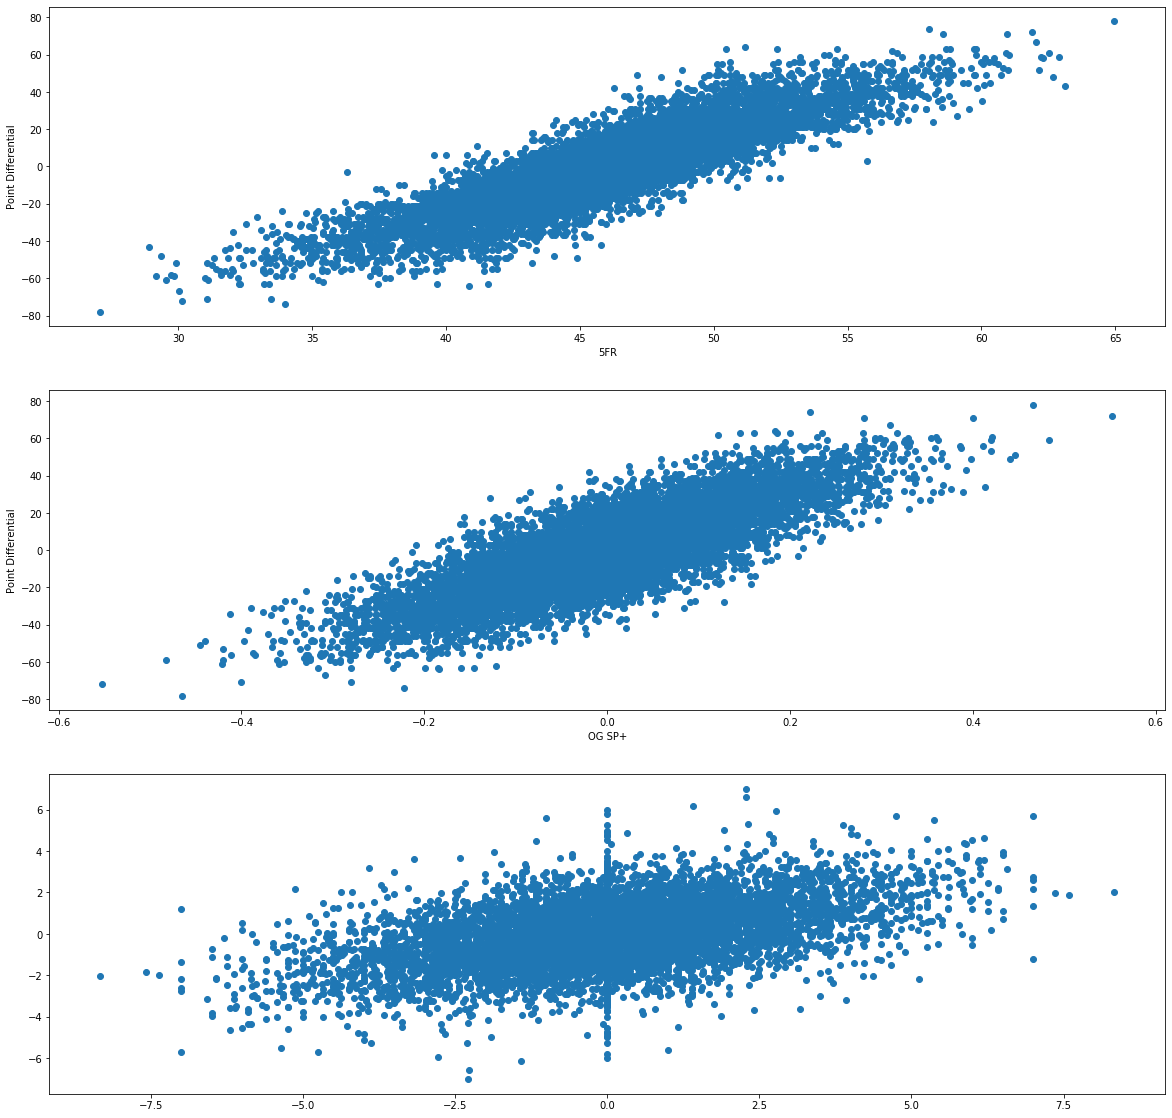

In [124]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(20, 20))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FR"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FR")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OppPPDDiff"],stored_game_boxes[f"ExpOppPPDDiff"]);
# axes[2].set_xlabel("S&P with IsoPPP")
# axes[2].set_ylabel("Point Differential");

In [125]:
# sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
# sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPPDiff"]
# correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
# correl.corr()

In [126]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,IsoPPPDiff,AvgEqPPPDiff,HavocRateDiff,FGEffDiff,ExpOppPPDDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0,0.04152,0.122680,0.020249,0.000000,1.064489,49.876856,2.423433,0.706656,1.899151
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0,-0.04152,-0.122680,-0.020249,0.000000,-1.064489,42.168134,-2.423433,0.706656,1.899151
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0,-0.42232,0.017305,0.034450,0.333333,-0.263693,48.208524,0.268980,0.078433,0.180871
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0,0.42232,-0.017305,-0.034450,-0.333333,0.263693,43.836465,-0.268980,0.078433,0.180871
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.26167,0.087917,0.050371,-0.750000,0.770308,44.628592,1.038490,0.302816,0.497397


In [127]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [128]:
# outliers

In [129]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,IsoPPPDiff,AvgEqPPPDiff,HavocRateDiff,FGEffDiff,ExpOppPPDDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0,0.041520,0.122680,0.020249,0.000000,1.064489,49.876856,2.423433,0.706656,1.899151
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0,0.422320,-0.017305,-0.034450,-0.333333,0.263693,43.836465,-0.268980,0.078433,0.180871
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.261670,0.087917,0.050371,-0.750000,0.770308,44.628592,1.038490,0.302816,0.497397
1,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,0,-0.261670,-0.087917,-0.050371,0.750000,-0.770308,47.416397,-1.038490,0.302816,0.497397
0,UMass,2012,322430041,0.0,-37.0,0.000005,0.148936,0.042553,2.382979,1.437239,...,-1,0.428001,-0.193136,-0.105045,-1.000000,-0.757723,38.414465,-2.239262,0.652953,1.673061


In [130]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)


In [147]:
# inpt_vars = pd.DataFrame()
# inpt_vars['Eff'] = train_data.apply(lambda x: create_eff_index(x), axis=1)
# inpt_vars['Expl'] = train_data.apply(lambda x: create_expl_index(x), axis=1) 
# inpt_vars['FinDrv'] = train_data.apply(lambda x: create_finish_drive_index(x), axis=1) 
# inpt_vars['FldPos'] = train_data.apply(lambda x: create_fp_index(x), axis=1) 
# inpt_vars['Trnovr'] = train_data.apply(lambda x: create_turnover_index(x), axis=1)

degree = 7
poly_reg = PolynomialFeatures(degree=degree)
X_poly = poly_reg.fit_transform(train_data['5FRDiff'][:, np.newaxis])
poly_model = LinearRegression()
poly_model.fit(X_poly, train_data['PtsDiff'][:, np.newaxis])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [150]:
#print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')
# opt_vars = pd.DataFrame()
# opt_vars['Eff'] = test_data.apply(lambda x: create_eff_index(x), axis=1)
# opt_vars['Expl'] = test_data.apply(lambda x: create_expl_index(x), axis=1) 
# opt_vars['FinDrv'] = test_data.apply(lambda x: create_finish_drive_index(x), axis=1) 
# opt_vars['FldPos'] = test_data.apply(lambda x: create_fp_index(x), axis=1) 
# opt_vars['Trnovr'] = test_data.apply(lambda x: create_turnover_index(x), axis=1)
def check_errors(mdl, inptVar):
    pred = mdl.predict(inptVar)
    
    print(f"Mean Pred Score: {pred.mean()}")
    print(f"Pred Std Dev: {pred.std()}")

    # MAPE is not a trustworthy measurement when the mean's going to be near zero
    # mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
    # print(f"MAPE: {mape}%")

    MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], pred)
    print(f"Mean Abs Error: {MAE}")

    MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], pred)
    print(f"Mdn Abs Error: {MdnAE}")

    corr_matx = {
        'ActPtsDiff' : test_data['PtsDiff'],
    }
    corr_matx['Eff'] = test_data.apply(lambda x: create_eff_index(x), axis=1)
    corr_matx['Expl'] = test_data.apply(lambda x: create_expl_index(x), axis=1) 
    corr_matx['FinDrv'] = test_data.apply(lambda x: create_finish_drive_index(x), axis=1) 
    corr_matx['FldPos'] = test_data.apply(lambda x: create_fp_index(x), axis=1) 
    corr_matx['Trnovr'] = test_data.apply(lambda x: create_turnover_index(x), axis=1) 
#     corr_matx
    corr_matx['PredPtsDiff'] = pred
    test = pd.DataFrame(corr_matx)
    print(f'R-squared: {r2_score(test["ActPtsDiff"][:,np.newaxis], pred)}\n')
    print(test.corr()['ActPtsDiff'])
    return pred

print(f"Linear")
preds = check_errors(model, test_data['5FRDiff'][:, np.newaxis])
print("---")
print(f"Poly Degree {degree}")
poly_preds = check_errors(poly_model, poly_reg.fit_transform(test_data['5FRDiff'][:, np.newaxis]))

Linear
Mean Pred Score: 0.09307643269115619
Pred Std Dev: 16.001144963438477
Mean Abs Error: 11.533453156292374
Mdn Abs Error: 9.453087767036973
R-squared: 0.5532903845399963

ActPtsDiff     1.000000
Eff            0.771475
Expl           0.723503
FinDrv         0.608249
FldPos         0.492210
Trnovr         0.562148
PredPtsDiff    0.743956
Name: ActPtsDiff, dtype: float64
---
Poly Degree 7
Mean Pred Score: 0.10668451617809552
Pred Std Dev: 16.026486487791203
Mean Abs Error: 11.516393087495421
Mdn Abs Error: 9.425974547292775


Exception: Data must be 1-dimensional

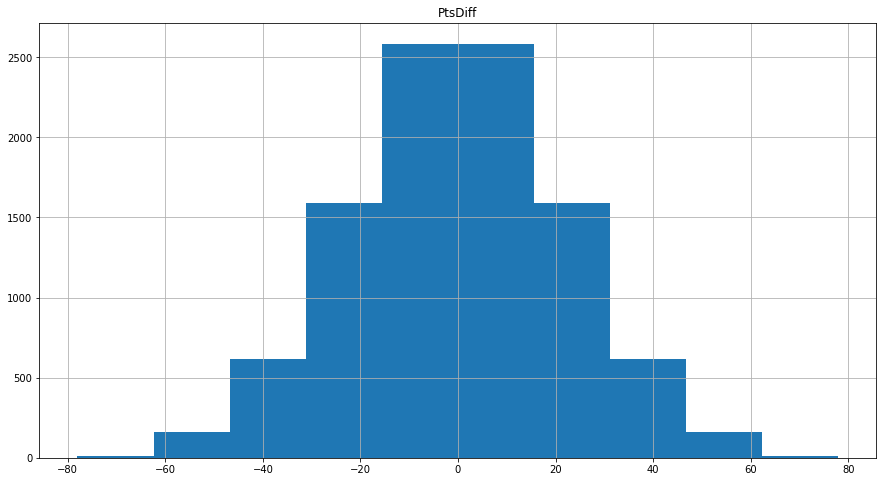

In [23]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

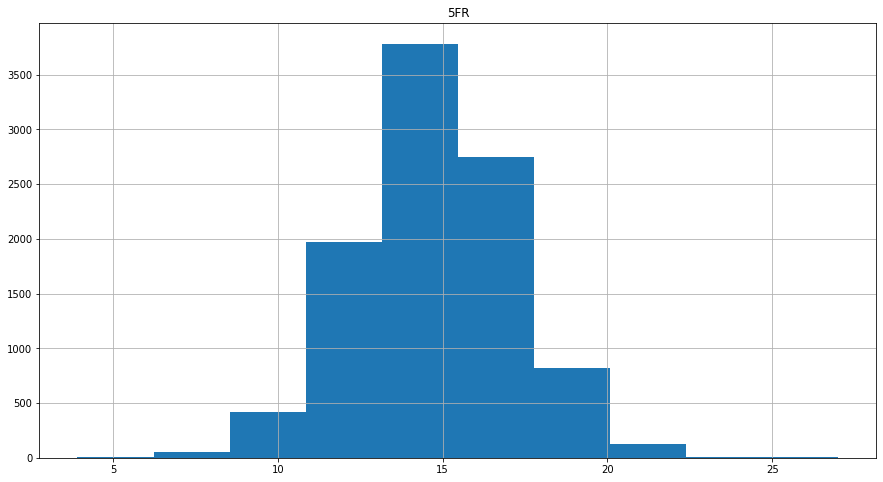

In [24]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

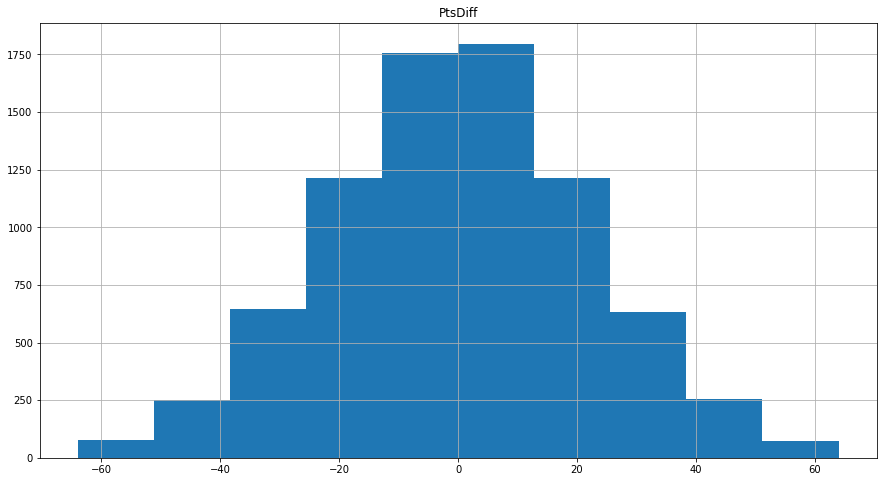

In [25]:
train_data.hist(column='PtsDiff', figsize=(15,8));

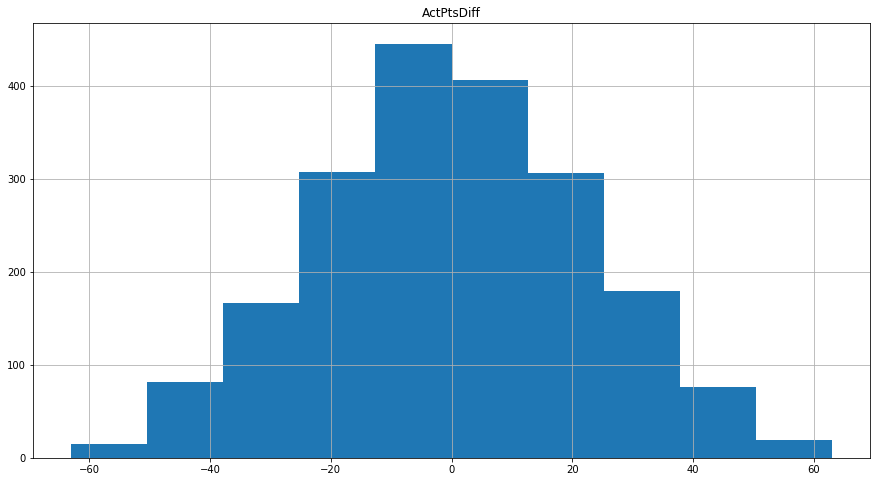

In [26]:
test.hist(column='ActPtsDiff', figsize=(15,8));

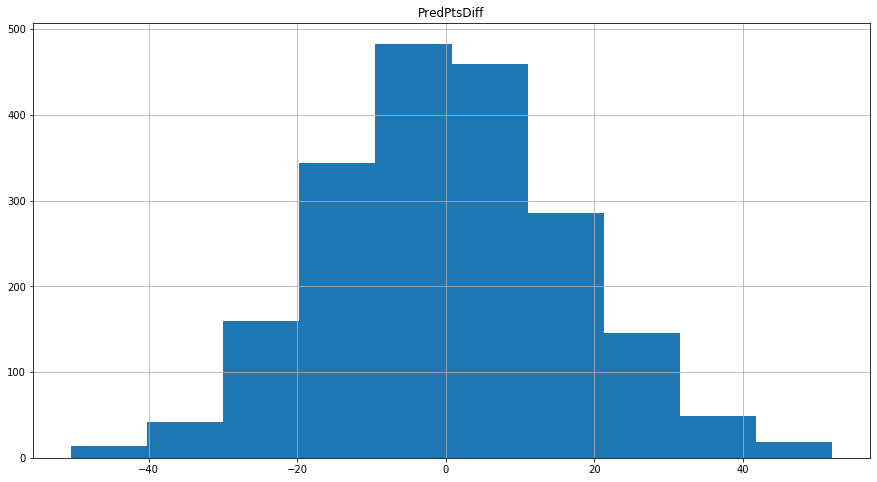

In [27]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [28]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")
    print("---")
    return stats.norm.cdf(z)

In [29]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -11.0 (exact value: -10.962977569576513)
Z score: -0.6894587347568337
Win Prob for Virginia Tech: 24.53%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,ExpTODiff,ActualTODiff,IsoPPPDiff,AvgEqPPPDiff,HavocRateDiff,FGEffDiff,ExpOppPPDDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,-0.66,-1,0.124959,0.103211,-0.033753,0.333333,1.110357,15.336947,2.306583
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,0.66,1,-0.124959,-0.103211,0.033753,-0.333333,-1.110357,13.030364,-2.306583


In [30]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -11.0 (exact value: -10.769046535443149)
Z score: -0.6776713933652818
Win Prob for Georgia Tech: 24.90%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,ExpTODiff,ActualTODiff,IsoPPPDiff,AvgEqPPPDiff,HavocRateDiff,FGEffDiff,ExpOppPPDDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.66,1,-0.121075,-0.014422,0.015791,0.0,-0.151428,13.431954,-2.266017
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.66,-1,0.121075,0.014422,-0.015791,0.0,0.151428,15.697971,2.266017


In [31]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -2.0 (exact value: -2.354083722316171)
Z score: -0.16620070524772518
Win Prob for Georgia Tech: 43.40%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,ExpTODiff,ActualTODiff,IsoPPPDiff,AvgEqPPPDiff,HavocRateDiff,FGEffDiff,ExpOppPPDDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,0.0,-2,-0.300725,-0.129463,0.010989,1.0,-0.690301,15.168729,0.505788
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,0.0,2,0.300725,0.129463,-0.010989,-1.0,0.690301,14.662941,-0.505788


In [32]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 3.0 (exact value: 2.6409819747323247)
Z score: 0.13740487756915587
Win Prob for Mississippi State: 55.46%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,ExpTODiff,ActualTODiff,IsoPPPDiff,AvgEqPPPDiff,HavocRateDiff,FGEffDiff,ExpOppPPDDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.070423,5.563380,0.880173,...,-0.059649,0.22,1,0.092249,0.020976,-0.003172,0,0.175441,12.885867,-0.539072
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.22,-1,-0.092249,-0.020976,0.003172,0,-0.175441,13.424939,0.539072


In [33]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by 5.0 (exact value: 5.42240014715387)
Z score: 0.3064625309638814
Win Prob for Texas A&M: 62.04%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,ExpTODiff,ActualTODiff,IsoPPPDiff,AvgEqPPPDiff,HavocRateDiff,FGEffDiff,ExpOppPPDDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.0,-1,-0.349878,-0.103285,0.004185,-0.25,-1.322644,14.372111,-1.120885
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,0.0,1,0.349878,0.103285,-0.004185,0.25,1.322644,15.492996,1.120885


In [34]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Clemson,0.895974,13,12.0,1.0
2,Alabama,0.883079,12,11.0,1.0
3,LSU,0.846417,13,11.0,2.0
4,Ohio State,0.844243,13,11.0,2.0
5,Baylor,0.809417,13,11.0,2.0
...,...,...,...,...,...
126,UMass,0.185366,12,2.0,10.0
127,Connecticut,0.156821,12,2.0,10.0
128,New Mexico State,0.143898,12,2.0,10.0
129,Rutgers,0.124720,12,1.0,11.0


In [35]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,10.174461,2.825539
21,Clemson,10.011496,2.988504
53,LSU,9.345289,3.654711
11,Baylor,9.031622,3.968378
2,Alabama,8.915396,3.084604
...,...,...,...
88,Rutgers,2.476642,9.523358
112,UMass,2.397105,9.602895
70,New Mexico State,2.351591,9.648409
25,Connecticut,2.229964,9.770036


In [36]:
# Matchup Predictor?
def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    if (~(teams[teams.school == team1].conference.isin(p5).all())):
        team1_avg_ffr *= 0.85 # arbitrary
    if (~(teams[teams.school == team2].conference.isin(p5).all())):
        team2_avg_ffr *= 0.85 # arbitrary
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.034866062718741674, -29.458662089579004]

In [37]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5] # Sugar Bowl
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Penn State,Memphis,7.0,13.886970,0.794162,True,Penn State,Penn State
0,LSU,Oklahoma,11.0,13.704917,0.790996,True,LSU,LSU
0,Clemson,Ohio State,2.5,12.316671,0.765929,True,Clemson,Clemson
0,Wisconsin,Oregon,2.5,-0.199227,0.485950,False,Oregon,Oregon
0,Florida,Virginia,14.0,-2.918011,0.420554,False,Virginia,Virginia
0,Georgia,Baylor,7.5,-4.997129,0.371891,False,Baylor,Baylor


In [38]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 20.0 (exact value: 20.410445078417567)
Z score: 1.2174523742667842
Win Prob for Virginia: 88.83%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,ExpTODiff,ActualTODiff,IsoPPPDiff,AvgEqPPPDiff,HavocRateDiff,FGEffDiff,ExpOppPPDDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,0.073684,0.66,3,-0.403644,-0.135068,-0.080026,0.0,-1.190773,15.453969,-4.256061
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,-0.073684,-0.66,-3,0.403644,0.135068,0.080026,0.0,1.190773,19.710031,4.256061


In [39]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by -1.0 (exact value: -0.7914762687453163)
Z score: -0.07122370685995487
Win Prob for North Carolina: 47.16%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,ExpTODiff,ActualTODiff,IsoPPPDiff,AvgEqPPPDiff,HavocRateDiff,FGEffDiff,ExpOppPPDDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.123887,0.0,-1,-0.235394,-0.01403,0.059725,0.5,-0.930481,15.034385,-0.178924
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.123887,0.0,1,0.235394,0.01403,-0.059725,-0.5,0.930481,15.213310,0.178924


In [40]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 1.0 (exact value: 1.462058181649161)
Z score: 0.06574859374746443
Win Prob for Pittsburgh: 52.62%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,ExpTODiff,ActualTODiff,IsoPPPDiff,AvgEqPPPDiff,HavocRateDiff,FGEffDiff,ExpOppPPDDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.20743,0.0,1,-0.248736,0.130501,0.016956,0.166667,0.184535,12.873403,0.292467
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.20743,0.0,-1,0.248736,-0.130501,-0.016956,-0.166667,-0.184535,12.580937,-0.292467


In [41]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -0.0 (exact value: -0.41752883171792865)
Z score: -0.04849477065624017
Win Prob for Auburn: 48.07%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,ExpTODiff,ActualTODiff,IsoPPPDiff,AvgEqPPPDiff,HavocRateDiff,FGEffDiff,ExpOppPPDDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,0.114729,0.44,1,-0.083465,0.063274,-0.032895,-0.5,0.076636,14.374851,0.100702
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,-0.114729,-0.44,-1,0.083465,-0.063274,0.032895,0.5,-0.076636,14.274149,-0.100702


In [42]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 18.0 (exact value: 17.661868233793538)
Z score: 1.0503908528693489
Win Prob for Georgia: 85.32%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,ExpTODiff,ActualTODiff,IsoPPPDiff,AvgEqPPPDiff,HavocRateDiff,FGEffDiff,ExpOppPPDDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,-0.047059,0.0,2,0.455922,0.330151,0.012116,0.5,2.418247,15.563535,3.681118
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,0.047059,0.0,-2,-0.455922,-0.330151,-0.012116,-0.5,-2.418247,11.882416,-3.681118


In [43]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)
    return prob if row.ActualMOV > 0 else 1-prob

def retrieve_win_probs(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame

retrieve_win_probs("Georgia Tech", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 15.0 (exact value: 15.491449648338744)
Z score: 0.918470425880179
Win Prob for Clemson: 82.08%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by -18.0 (exact value: -17.823277193399633)
Z score: -1.1064352855997899
Win Prob for Georgia Tech: 13.43%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -26.0 (exact value: -25.9787645831543)
Z score: -1.6021347723122967
Win Prob for The Citadel: 5.46%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 8.0 (exact value: 8.353567029860802)
Z score: 0.48462207554877385
Win Prob for Temple: 68.60%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by -1.0 (exact value: -0.7914762687453163)
Z score: -0.0712237068

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5805,401111653,2019,Georgia Tech,Clemson,-38.0,17.918632
5900,401112441,2019,Georgia Tech,South Florida,4.0,13.426908
5967,401112452,2019,Georgia Tech,The Citadel,-3.0,94.543709
6106,401112469,2019,Georgia Tech,Temple,-22.0,31.397223
6165,401112475,2019,Georgia Tech,North Carolina,-16.0,52.839014
6198,401112480,2019,Georgia Tech,Duke,-18.0,62.103833
6251,401112488,2019,Georgia Tech,Miami,7.0,24.899003
6384,401112498,2019,Georgia Tech,Pittsburgh,-10.0,47.378899
6418,401112504,2019,Georgia Tech,Virginia,-5.0,54.874213
6480,401112511,2019,Georgia Tech,Virginia Tech,-45.0,0.012211


In [44]:
# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)